In [1]:
import numpy as np
import pandas as pd
import xlrd
import xlwt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import jupyterlab
import statsmodels.api as sm
from pandas_profiling import ProfileReport 
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

Pandas backend loaded 1.3.4
Numpy backend loaded 1.19.5
Pyspark backend NOT loaded
Python backend loaded


In [2]:
training = pd.read_csv('processedTrain.csv')

In [3]:
training.loc[training.AVERAGE_SPEED_DIFF == 'None', 'AVERAGE_SPEED_DIFF'] = '0'
training.loc[training.AVERAGE_SPEED_DIFF == 'Low', 'AVERAGE_SPEED_DIFF'] = '1'
training.loc[training.AVERAGE_SPEED_DIFF == 'Medium', 'AVERAGE_SPEED_DIFF'] = '2'
training.loc[training.AVERAGE_SPEED_DIFF == 'High', 'AVERAGE_SPEED_DIFF'] = '3'
training.loc[training.AVERAGE_SPEED_DIFF == 'Very_High', 'AVERAGE_SPEED_DIFF'] = '4'

In [4]:

X = training.drop(['AVERAGE_SPEED_DIFF'],axis=1)
y = training[['AVERAGE_SPEED_DIFF']]


In [5]:
y = to_categorical(y, 5)


In [6]:
scaler_X = MinMaxScaler(feature_range=(0,1)).fit(X)
#scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]),columns=X.columns)
#y_scaled = pd.DataFrame(scaler_y.transform(y[y.columns]),columns=y.columns)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=2021)

In [8]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

C:\Users\Krow\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4], y=[2 3 3 ... 0 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [9]:
d_class_weights

{0: 0.6192727272727273,
 1: 0.9601127554615927,
 2: 0.8251968503937008,
 3: 1.2816556914393227,
 4: 2.844258872651357}

In [10]:
custom_class_weights={
 0: 0.6192727272727273,
 1: 1,
 2: 1.05,
 3: 1.3816556914393227,
 4: 2.844258872651357}

In [11]:
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import relu
from tensorflow.keras.activations import elu
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import logcosh
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
import keras_tuner as kt
from keras.layers import Flatten
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters as hp
from keras.callbacks import EarlyStopping

C:\Users\Krow\AppData\Local\Temp/ipykernel_7536/1285688646.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [12]:
def model_create(hp):
    model = tf.keras.models.Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))

    model.add(Dense(units=hp.Int('units',
                                  min_value=2,
                                  max_value=64,
                                  step=6),
                                  activation='relu'))
    
    model.add(
            Dropout(rate=hp.Float(
                'dropout_start',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))

    for i in range(hp.Int('n_layers',0,2)):
        model.add(Dense(units=hp.Int(f'conv_{i}_units',
                                  min_value=2,
                                  max_value=64,
                                  step=6),
                                  activation='relu'))
        model.add(
            Dropout(rate=hp.Float(
                f'dropout_{i}',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
                                  
    

    model.add(Dense(5,activation='softmax'))

    model.compile(
    optimizer=Adam(hp.Choice('learning_rate',
                        values=[1e-2,1e-3,1e-4])),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

    return model             

In [13]:
tuner = RandomSearch(
     model_create,
     objective='val_categorical_accuracy',
     max_trials=40,
     executions_per_trial=5,
     project_name='traffic',
     directory='/home/krow/Documents/DAA/KaggleV3',
     overwrite = True
     
)

In [14]:
#tuner.search(X_train,y_train,epochs=5,validation_split=0.2)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [16]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [17]:
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [18]:
#model = tuner.hypermodel.build(best_hps)

In [19]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=200,class_weight=custom_class_weights)

Epoch 1/200
171/171 [==============================] - 1s 1ms/step - loss: 1.5952 - categorical_accuracy: 0.3740 - val_loss: 1.2052 - val_categorical_accuracy: 0.5172
Epoch 2/200
171/171 [==============================] - 0s 848us/step - loss: 1.3455 - categorical_accuracy: 0.4595 - val_loss: 1.0246 - val_categorical_accuracy: 0.5752
Epoch 3/200
171/171 [==============================] - 0s 860us/step - loss: 1.1443 - categorical_accuracy: 0.5219 - val_loss: 0.8797 - val_categorical_accuracy: 0.6354
Epoch 4/200
171/171 [==============================] - 0s 854us/step - loss: 1.0165 - categorical_accuracy: 0.5707 - val_loss: 0.8048 - val_categorical_accuracy: 0.6691
Epoch 5/200
171/171 [==============================] - 0s 824us/step - loss: 0.9421 - categorical_accuracy: 0.6161 - val_loss: 0.7508 - val_categorical_accuracy: 0.7029
Epoch 6/200
171/171 [==============================] - 0s 813us/step - loss: 0.8862 - categorical_accuracy: 0.6328 - val_loss: 0.6904 - val_categorical_accur

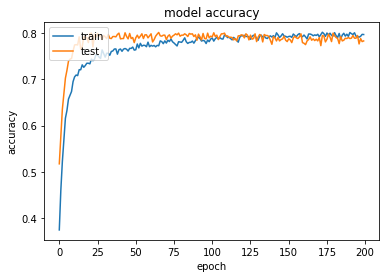

In [20]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

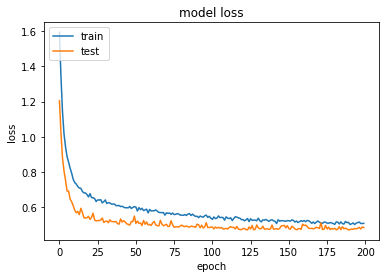

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
evaluation = model.evaluate(X_test,y_test)
print('test loss, test accuracy',evaluation)

43/43 [==============================] - 0s 429us/step - loss: 0.4817 - categorical_accuracy: 0.7836
test loss, test accuracy [0.48171642422676086, 0.7835656404495239]


In [23]:
predictions = model.predict(X_test)

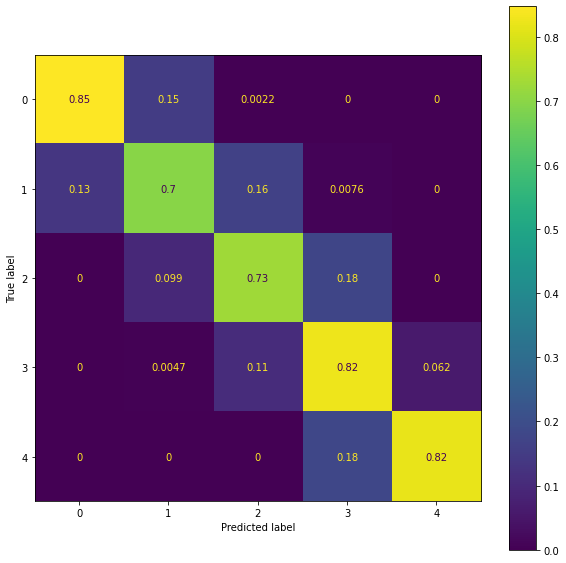

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cmn)
fig, ax = plt.subplots(figsize=(10, 10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
disp.plot(ax = ax)
plt.show()

In [ ]:
testing = pd.read_csv('processedTest.csv')

In [ ]:
testing_scaled = pd.DataFrame(scaler_X.transform(testing[testing.columns]),columns=testing.columns)

In [ ]:
predict_x=model.predict(testing_scaled) 
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
prediction = pd.DataFrame({'AVERAGE_SPEED_DIFF': classes_x})

In [ ]:
prediction.loc[prediction.AVERAGE_SPEED_DIFF == 0, 'AVERAGE_SPEED_DIFF'] = 'None'
prediction.loc[prediction.AVERAGE_SPEED_DIFF == 1, 'AVERAGE_SPEED_DIFF'] = 'Low'
prediction.loc[prediction.AVERAGE_SPEED_DIFF == 2, 'AVERAGE_SPEED_DIFF'] = 'Medium'
prediction.loc[prediction.AVERAGE_SPEED_DIFF == 3, 'AVERAGE_SPEED_DIFF'] = 'High'
prediction.loc[prediction.AVERAGE_SPEED_DIFF == 4, 'AVERAGE_SPEED_DIFF'] = 'Very_High'


In [ ]:
sub_df = pd.read_csv('example_submission.csv')
final_data = {'RowId': sub_df.RowId, 'Speed_Diff': prediction.AVERAGE_SPEED_DIFF}
submission = pd.DataFrame(data=final_data)

In [ ]:
compare = pd.read_csv('sample_submission.csv')

In [ ]:
submission['Speed_Diff'].value_counts()

Medium       430
Low          387
None         305
High         271
Very_High    107
Name: Speed_Diff, dtype: int64

In [ ]:
compare['Speed_Diff'].value_counts()

None         482
Medium       340
Low          313
High         268
Very_High     97
Name: Speed_Diff, dtype: int64

In [ ]:
df1 = np.where(submission['Speed_Diff'] == compare['Speed_Diff'], 'True', 'False')
df1 = pd.DataFrame(df1)
df1.columns=['equals']
df1.value_counts()

equals
True      1012
False      488
dtype: int64

In [ ]:
#submission.to_csv('submission.csv',index=False)